# 📝 Notebook: Aplicación y Verificación de Transformaciones (Box-Cox & Diferenciación)

### **Paso 1: Configuración, Carga de Datos y Verificación de Requisitos**

Cargamos las librerías necesarias y el DataFrame. Verificamos que se cumpla el requisito crucial de Box-Cox: todos los datos deben ser positivos ($Y_t > 0$).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox # Para la transformación de Box-Cox
from statsmodels.tsa.stattools import adfuller # Para el Test ADF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Para ACF y PACF
import warnings
warnings.filterwarnings("ignore")

# --- CARGA Y PREPARACIÓN DE DATOS ---
try:
    # Intenta cargar el archivo directamente desde la raíz o el directorio "dataset"
    df = pd.read_csv('pinar_del_rio_temperaturas_LIMPIO_FINAL.csv')
except FileNotFoundError:
    df = pd.read_csv('dataset/pinar_del_rio_temperaturas_LIMPIO_FINAL.csv')

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.set_index('Fecha')

# Verificación de requisitos
min_temp = df[['Temp_Maxima_C', 'Temp_Minima_C']].min().min()
print(f"✅ Datos cargados. Mínima temperatura observada: {min_temp:.1f}°C")

if min_temp > 0:
    print("El requisito de Box-Cox (Y_t > 0) se cumple.")
else:
    print("⚠️ ADVERTENCIA: Box-Cox no puede aplicarse a datos no positivos. Se requeriría un ajuste (ej. añadir una constante).")


✅ Datos cargados. Mínima temperatura observada: 12.8°C
El requisito de Box-Cox (Y_t > 0) se cumple.


### **Paso 2: Optimización Box-Cox (Estabilizar Varianza)**

La función boxcox de scipy.stats encuentra automáticamente el parámetro $\lambda$ (lambda) que minimiza la desviación estándar (estabiliza la varianza) de la serie.

**Importante:** Lo aplicamos antes de la diferenciación.

In [12]:
# --- OPTIMIZACIÓN BOX-COX ---

# 1. Obtener lambda óptimo para Temp Máxima
data_max = df['Temp_Maxima_C'].values
# El primer valor que devuelve boxcox son los datos transformados; el segundo es el lambda.
_, lambda_max = boxcox(data_max) 

# 2. Obtener lambda óptimo para Temp Mínima
data_min = df['Temp_Minima_C'].values
_, lambda_min = boxcox(data_min)

print("\n=======================================================")
print(f"Lambda Óptimo (Box-Cox) Temp Máxima: λ = {lambda_max:.4f}")
print(f"Lambda Óptimo (Box-Cox) Temp Mínima: λ = {lambda_min:.4f}")
print("=======================================================")

# Aplicar Box-Cox a las series originales
df['BoxCox_Max'] = boxcox(df['Temp_Maxima_C'], lmbda=lambda_max)
df['BoxCox_Min'] = boxcox(df['Temp_Minima_C'], lmbda=lambda_min)
print("✅ Transformación Box-Cox aplicada para estabilizar la varianza.")


Lambda Óptimo (Box-Cox) Temp Máxima: λ = 4.3777
Lambda Óptimo (Box-Cox) Temp Mínima: λ = 4.2651
✅ Transformación Box-Cox aplicada para estabilizar la varianza.


### **Paso 3: Diferenciación (Estabilizar Media)**

Aplicamos la diferenciación de orden 1 (.diff(1)) a las series que ya tienen la varianza estabilizada. Esto elimina la tendencia y nos deja con la serie **estacionaria.**

In [13]:
# --- DIFERENCIACIÓN (d=1) ---

# Aplicar Diferenciación de orden 1 (Estabilizar Media) a las series Box-Cox
df['Diff_BoxCox_Max'] = df['BoxCox_Max'].diff(1)
df['Diff_BoxCox_Min'] = df['BoxCox_Min'].diff(1)

# Crear el DataFrame estacionario, eliminando el NaN inicial de la diferenciación
df_stationary = df[['Diff_BoxCox_Max', 'Diff_BoxCox_Min']].dropna()
N_stationary = len(df_stationary)

print(f"✅ Series Box-Cox Diferenciadas creadas. Tamaño (N): {N_stationary} puntos.")

✅ Series Box-Cox Diferenciadas creadas. Tamaño (N): 670 puntos.


### **Paso 4: Verificación Formal (Test ADF)**

Ejecutamos el Test Aumentado de Dickey-Fuller (ADF) para confirmar formalmente que la serie es estacionaria en media (rechazar la hipótesis nula $H_0$).

In [14]:
# --- VERIFICACIÓN FINAL: TEST ADF ---

def run_adf_test(series, name):
    """Ejecuta y muestra los resultados del Test ADF."""
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    
    print(f"\n--- Prueba ADF para {name} ---")
    print(f"Estadístico de Prueba (ADF): {result[0]:.4f}")
    print(f"p-valor: {p_value:.8f}")
    
    if p_value <= 0.05:
        print("➡️ Conclusión: p < 0.05. Se RECHAZA H0. La serie es ESTACIONARIA.")
    else:
        print("➡️ Conclusión: p >= 0.05. NO se rechaza H0. La serie NO es estacionaria.")

# 4.1. Test para Temp Máxima Transformada
run_adf_test(df_stationary['Diff_BoxCox_Max'], 'Temp_Maxima_C (Box-Cox Diff)')

# 4.2. Test para Temp Mínima Transformada
run_adf_test(df_stationary['Diff_BoxCox_Min'], 'Temp_Minima_C (Box-Cox Diff)')


--- Prueba ADF para Temp_Maxima_C (Box-Cox Diff) ---
Estadístico de Prueba (ADF): -10.0091
p-valor: 0.00000000
➡️ Conclusión: p < 0.05. Se RECHAZA H0. La serie es ESTACIONARIA.

--- Prueba ADF para Temp_Minima_C (Box-Cox Diff) ---
Estadístico de Prueba (ADF): -7.2160
p-valor: 0.00000000
➡️ Conclusión: p < 0.05. Se RECHAZA H0. La serie es ESTACIONARIA.


### **Paso 5: Análisis de Patrones (ACF y PACF Corregidos)**

Este paso es donde corregimos el error que mencionaste. Limitamos el número de lags al máximo permitido por la librería (N/2 - 1). El objetivo ahora no es la estacionariedad, sino **identificar los órdenes AR y MA** para el modelo VARIMA/SARIMAX.

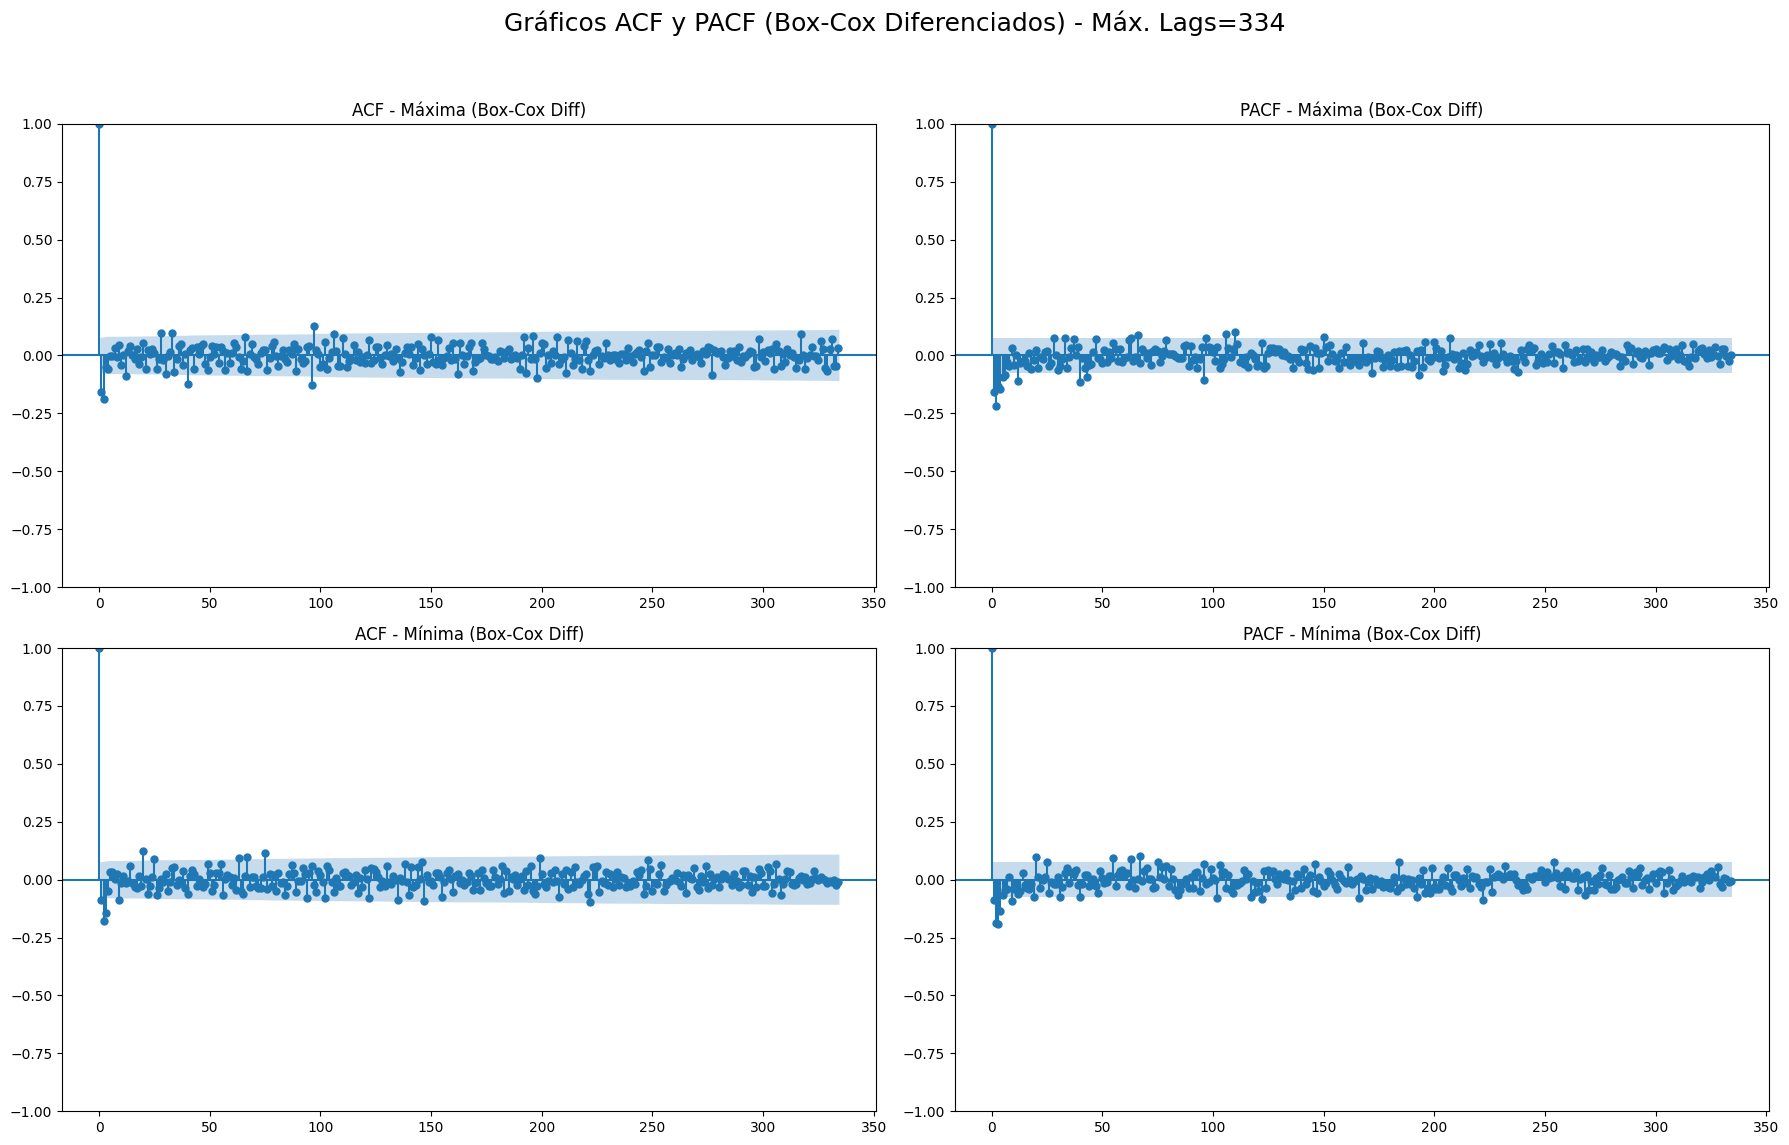

In [15]:
# --- ANÁLISIS FINAL: GRÁFICOS ACF y PACF ---

# CORRECCIÓN DEL ERROR:
# El máximo lag permitido para PACF es N/2 - 1. 
lags = N_stationary // 2 - 1 # N_stationary es 670, por lo que lags es 334.

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
plt.suptitle(f'Gráficos ACF y PACF (Box-Cox Diferenciados) - Máx. Lags={lags}', fontsize=18)

# Temp_Maxima_C
plot_acf(df_stationary['Diff_BoxCox_Max'], lags=lags, ax=axes[0, 0], title='ACF - Máxima (Box-Cox Diff)')
plot_pacf(df_stationary['Diff_BoxCox_Max'], lags=lags, ax=axes[0, 1], title='PACF - Máxima (Box-Cox Diff)', method='ywm')

# Temp_Minima_C
plot_acf(df_stationary['Diff_BoxCox_Min'], lags=lags, ax=axes[1, 0], title='ACF - Mínima (Box-Cox Diff)')
plot_pacf(df_stationary['Diff_BoxCox_Min'], lags=lags, ax=axes[1, 1], title='PACF - Mínima (Box-Cox Diff)', method='ywm')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **Próximo paso:**

El siguiente paso será en un nuevo notebook guardar en un csv y un un json los datos transformados y las constantes ya que las transformaciones ayudaron a que las series fueran estacionarias